In [1]:
%cd ..

/Users/justin/Projects/MA-thesis


In [2]:
import glob
import pickle

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Spectrograms

Plot a spectrogram

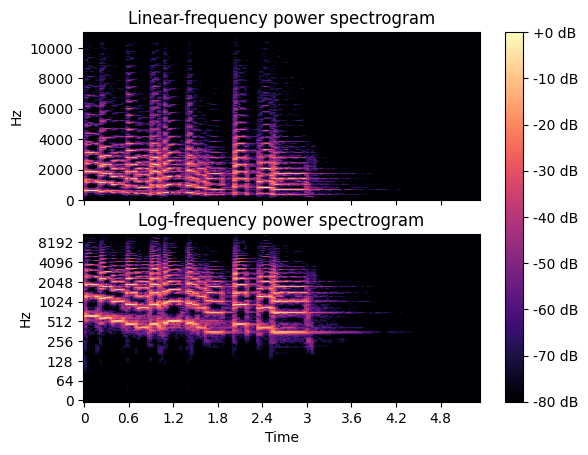

In [6]:
y, sr = librosa.load(librosa.ex('trumpet'))
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

And the Constant-Q Transform Spectrogram

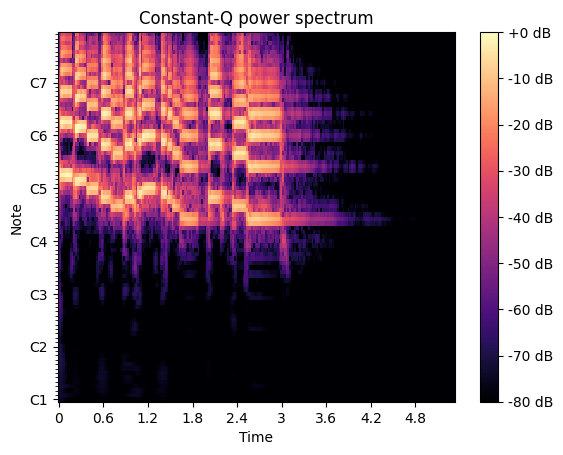

In [7]:
C = np.abs(librosa.cqt(y, sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## Classification Errors and Fitness

In [6]:
colors = ["#abdda4", "#2b83ba", "#d7191c"]

Single Onset Experiments

In [26]:
def parse_experiment_errors(error_file):
    with open(error_file, "rb") as fp:
        errors = pickle.load(fp)

    # Parse errors into types
    errors_padded = []
    max_len = max([len(run) for run in errors])
    for run in errors:  
        while len(run) < max_len:
            run.append((0, 0, 0))
        errors_padded.append(run)
    j_i_runs = [[tup[0] for tup in run] for run in errors_padded]
    j_p_runs = [[tup[1] for tup in run] for run in errors_padded]
    j_ip_runs = [[tup[2] for tup in run] for run in errors_padded]
    j_i_means = np.mean(j_i_runs, axis=0)
    j_p_means = np.mean(j_p_runs, axis=0)
    j_ip_means = np.mean(j_ip_runs, axis=0)

    return j_i_means, j_p_means, j_ip_means

In [32]:
error_file = f"./experiments/ground_truth_scan/10k_baseline_errors.pkl"
fitness_file = f"./experiments/ground_truth_scan/10k_baseline_errors.pkl"
j_i_means, j_p_means, j_ip_means = parse_experiment_errors(error_file)

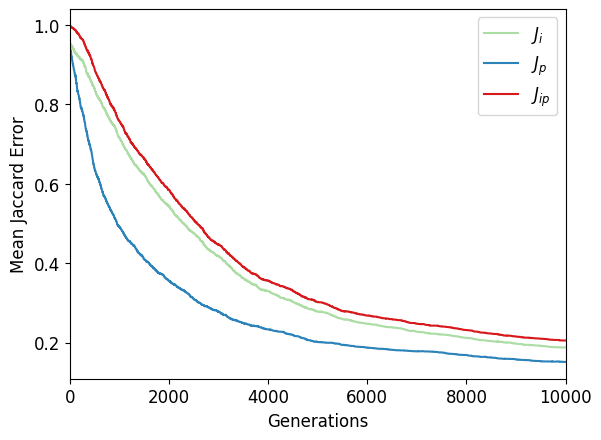

In [33]:
plt.rcParams.update({'font.size': 12})
plt.plot(j_i_means, label=r"$J_i$", color=colors[0])
plt.plot(j_p_means, label=r"$J_p$", color=colors[1])
plt.plot(j_ip_means, label=r"$J_{ip}$", color=colors[2])
plt.xlabel("Generations")
plt.xlim((0, 10000))
plt.ylabel("Mean Jaccard Error")
plt.legend()

### Dual Plots with Zoom on first 500 Generations

In [45]:
error_file = f"./experiments/ground_truth_scan/preprocess_mut_min_errors.pkl"

j_i_means, j_p_means, j_ip_means = parse_experiment_errors(error_file)

Text(0.5, 0.98, 'Parameters: $\\alpha=1$, $\\beta=1$, $u_{bound}=1$')

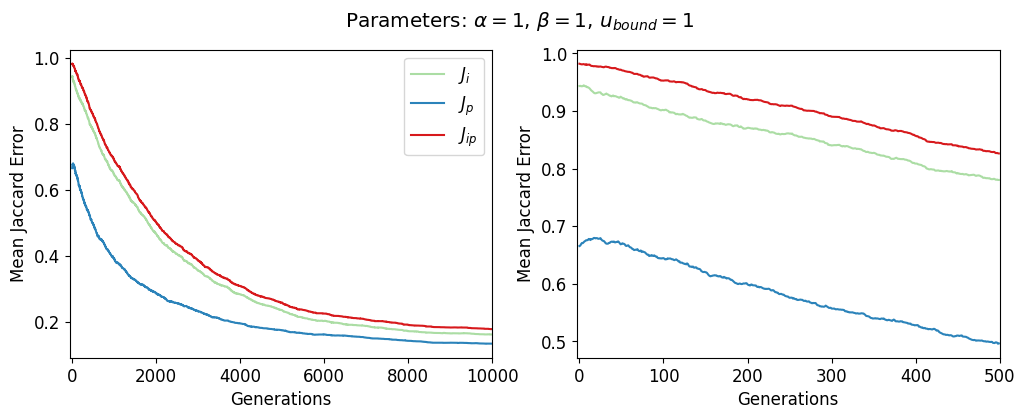

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(j_i_means, label=r"$J_i$", color=colors[0])
ax[0].plot(j_p_means, label=r"$J_p$", color=colors[1])
ax[0].plot(j_ip_means, label=r"$J_{ip}$", color=colors[2])
ax[0].set_xlim((-60, 10000))
ax[0].set_xlabel("Generations")
ax[0].set_ylabel("Mean Jaccard Error")
ax[0].legend()
ax[1].plot(np.arange(0, 500), j_i_means[0:500], label=r"$J_i$", color=colors[0])
ax[1].plot(np.arange(0, 500), j_p_means[0:500], label=r"$J_p$", color=colors[1])
ax[1].plot(np.arange(0, 500), j_ip_means[0:500], label=r"$J_{ip}$", color=colors[2])
ax[1].set_xlim((-3, 500))
ax[1].set_xlabel("Generations")
ax[1].set_ylabel("Mean Jaccard Error")
#ax[1].legend(fontsize='x-small')
fig.suptitle(r"Parameters: $\alpha=1$, $\beta=1$, $u_{bound}=1$") # Please refer to ground_truth_scan.csv

### Multi-Onset Experiments (Full Piece, AAM Dataset)

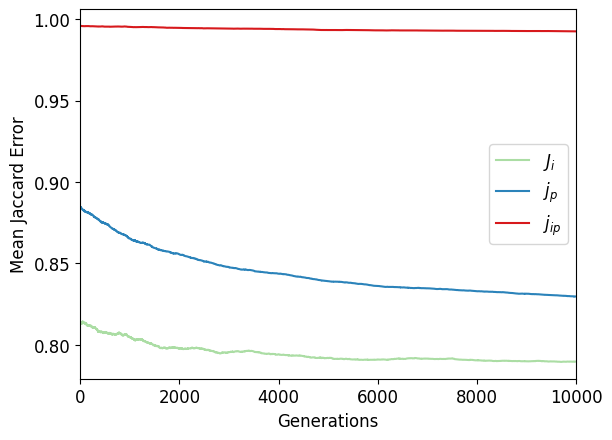

In [55]:
experiment_name = "/tiny_aam/300_1_10000_0.05_5_10_1_20_0.9954_15_20_1sec_preprocess"
root_path = f"./experiments/{experiment_name}/"
csv_files = glob.glob(root_path + "**/*.csv", recursive=True)
j_i, j_p, j_ip, fitness = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i, file in enumerate(csv_files):
    df = pd.read_csv(file)
    j_i = pd.concat([j_i, df["j_i"]], axis=1)
    j_p = pd.concat([j_p, df["j_p"]], axis=1)
    j_ip = pd.concat([j_ip, df["j_ip"]], axis=1)
    fitness = pd.concat([fitness, df["fitness"]], axis=1)
df = pd.DataFrame({r"$J_i$":list(j_i.mean(axis=1)), r"$j_p$":list(j_p.mean(axis=1)), r"$j_{ip}$":list(j_ip.mean(axis=1))})
df_fit = fitness.mean(axis=1)
ax = df.plot(xlabel="Generations", ylabel="Mean Jaccard Error", xlim=(0, 10000))
for i, l in enumerate(ax.lines):
    plt.setp(l, color=colors[i])
plt.legend()

<Axes: xlabel='Generations', ylabel='Mean Fitness'>

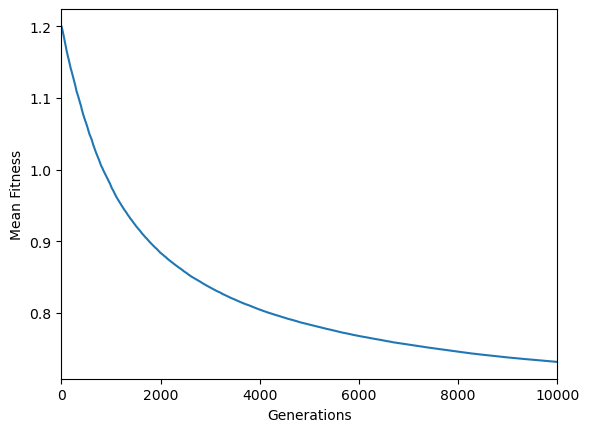

In [18]:
df_fit.plot(xlabel="Generations", ylabel="Mean Fitness", xlim=(0, 10000))

In [48]:
# Baseline
experiment_name = "tiny_aam/300_1_10000_0.05_5_10_1_20_0.9954_15_10_1sec_convlog"
root_path = f"./experiments/{experiment_name}/"
csv_files = glob.glob(root_path + "**/*.csv", recursive=True)
j_i, j_p, j_ip, fitness = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i, file in enumerate(csv_files):
    df = pd.read_csv(file)
    j_i = pd.concat([j_i, df["j_i"]], axis=1)
    j_p = pd.concat([j_p, df["j_p"]], axis=1)
    j_ip = pd.concat([j_ip, df["j_ip"]], axis=1)
    fitness = pd.concat([fitness, df["fitness"]], axis=1)
df_base = pd.DataFrame({"j_i":list(j_i.mean(axis=1)), "j_p":list(j_p.mean(axis=1)), "j_ip":list(j_ip.mean(axis=1))})
df_fit_base = fitness.mean(axis=1)

In [50]:
# Preprocessed with baseline mutation strength
experiment_name = "tiny_aam/300_1_10000_0.05_5_10_1_20_0.9954_15_20_1sec_preprocess"
root_path = f"./experiments/{experiment_name}/"
csv_files = glob.glob(root_path + "**/*.csv", recursive=True)
j_i, j_p, j_ip, fitness = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i, file in enumerate(csv_files):
    df = pd.read_csv(file)
    j_i = pd.concat([j_i, df["j_i"]], axis=1)
    j_p = pd.concat([j_p, df["j_p"]], axis=1)
    j_ip = pd.concat([j_ip, df["j_ip"]], axis=1)
    fitness = pd.concat([fitness, df["fitness"]], axis=1)
df_preprocess = pd.DataFrame({"j_i":list(j_i.mean(axis=1)), "j_p":list(j_p.mean(axis=1)), "j_ip":list(j_ip.mean(axis=1))})
df_fit_preprocess = fitness.mean(axis=1)

In [49]:
# Preprocessed with less mutation strength
experiment_name = "tiny_aam/300_1_10000_0.05_5_5_1_8_0.9954_15_20_1sec_preprocess"
root_path = f"./experiments/{experiment_name}/"
csv_files = glob.glob(root_path + "**/*.csv", recursive=True)
j_i, j_p, j_ip, fitness = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i, file in enumerate(csv_files):
    df = pd.read_csv(file)
    j_i = pd.concat([j_i, df["j_i"]], axis=1)
    j_p = pd.concat([j_p, df["j_p"]], axis=1)
    j_ip = pd.concat([j_ip, df["j_ip"]], axis=1)
    fitness = pd.concat([fitness, df["fitness"]], axis=1)
df_preprocess_less = pd.DataFrame({"j_i":list(j_i.mean(axis=1)), "j_p":list(j_p.mean(axis=1)), "j_ip":list(j_ip.mean(axis=1))})
df_fit_preprocess_less = fitness.mean(axis=1)

/var/folders/29/817512nn0_jcnzq5mh7p09900000gn/T/ipykernel_3857/341286446.py:9: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x173f1b690> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=["_nolegend_", "_nolegend_", "_nolegend_", r"$J_i$", r"$J_p$", r"$J_{ip}$"])
/var/folders/29/817512nn0_jcnzq5mh7p09900000gn/T/ipykernel_3857/341286446.py:9: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x173f1c890> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=["_nolegend_", "_nolegend_", "_nolegend_", r"$J_i$", r"$J_p$", r"$J_{ip}$"])
/var/folders/29/817512nn0_jcnzq5mh7p09900000gn/T/ipykernel_3857/341286446.py:9: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x173f1dfd0> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=["_nolegend_", "_nolegend_", "_nolegend_", r"$J_i$", r"$J_p$", r"$J_{ip}$"])


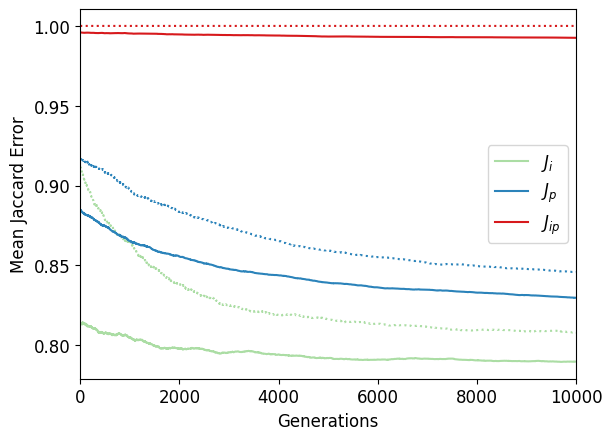

In [58]:
# Compare baseline and pre-process
fig, ax = plt.subplots()

# Baseline (Run code cell above first)
df_base.plot(xlabel="Generations", ylabel="Mean Jaccard Error", xlim=(0, 10000), ax=ax, linestyle="dotted", color=colors)

# Pre-processed base
df_preprocess.plot(xlabel="Generations", ylabel="Mean Jaccard Error", xlim=(0, 10000), ax=ax, linestyle="solid", color=colors)
ax.legend(labels=["_nolegend_", "_nolegend_", "_nolegend_", r"$J_i$", r"$J_p$", r"$J_{ip}$"])
# Pre-processed less mutation strength
# df_preprocess_less.plot(xlabel="Generations", ylabel="Mean Jaccard Error", xlim=(0, 10000), ax=ax, linestyle="solid", color=["tab:blue", "tab:orange", "tab:green"])

/var/folders/29/817512nn0_jcnzq5mh7p09900000gn/T/ipykernel_3857/1288720202.py:9: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x173e57b50> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=["_nolegend_", "Mean Fitness"])


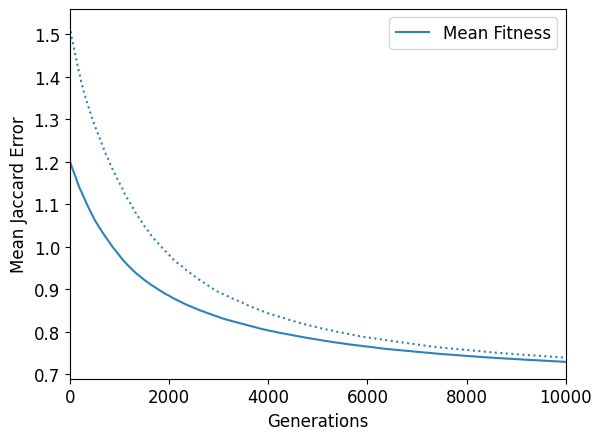

In [57]:
# Compare baseline and pre-process
fig, ax = plt.subplots()

# Baseline (Run code cell above first)
df_fit_base.plot(xlabel="Generations", ylabel="Mean Jaccard Error", xlim=(0, 10000), ax=ax, linestyle="dotted", color=[colors[1]])

# Pre-processed base
df_fit_preprocess.plot(xlabel="Generations", ylabel="Mean Jaccard Error", xlim=(0, 10000), ax=ax, linestyle="solid", color=[colors[1]])
ax.legend(labels=["_nolegend_", "Mean Fitness"])
# Pre-processed less mutation strength
# df_preprocess_less.plot(xlabel="Generations", ylabel="Mean Jaccard Error", xlim=(0, 10000), ax=ax, linestyle="solid", color=["tab:blue", "tab:orange", "tab:green"])

### Plotting extracted pitch probabilities

In [4]:
import librosa
from evoaudio.individual import BaseIndividual
from evoaudio.sample_library import SampleLibrary
from evoaudio.pitch import Pitch

In [5]:
lib = SampleLibrary()

Loading samples: 100%|██████████| 6826/6826 [00:13<00:00, 503.83it/s]


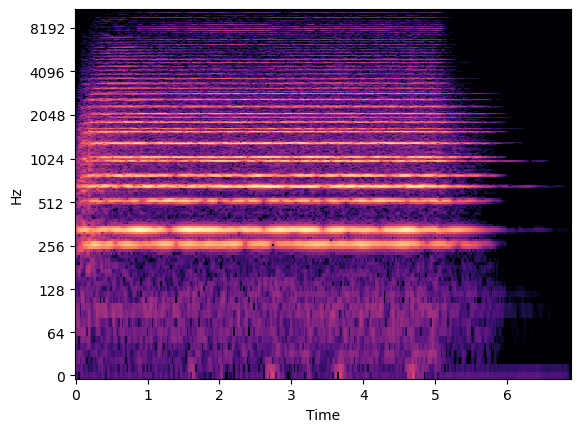

In [20]:
sr = 22050
targets = [("Trumpet", Pitch.c4), ("Trombone", Pitch.e4)]
ind = BaseIndividual()
ind.samples = [lib.get_sample(instrument=tup[0], pitch=tup[1]) for tup in targets]
mix = ind.to_mixdown()
D = librosa.amplitude_to_db(np.abs(librosa.stft(mix)), ref=np.max)
img = librosa.display.specshow(D, y_axis='log', x_axis='time',
                               sr=sr)

In [ ]:
bins_per_octave = 12
fmin = librosa.note_to_hz("f0")
cqt = librosa.cqt(mix, sr=sr, n_bins=88, bins_per_octave=bins_per_octave, fmin=fmin)
log_cqt = librosa.amplitude_to_db(np.abs(cqt))
librosa.display.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=bins_per_octave, fmin=fmin)

In [33]:
np.max(np.abs(cqt))

2.162541

<BarContainer object of 89 artists>

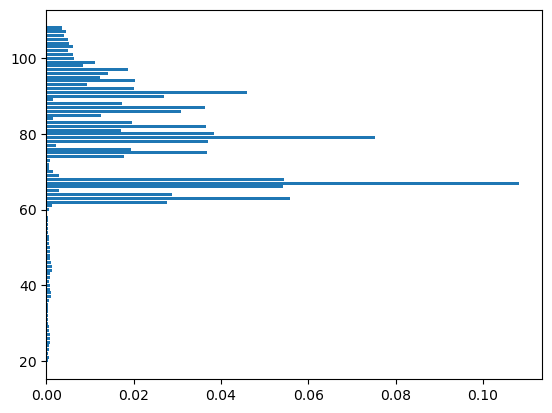

In [36]:
def extract_pitch_probabilities(y, sr=22050, n_bins=89, bins_per_octave=12, fmin=librosa.note_to_hz("f0")):
    """Estimates the pitches in the given signal y and turns
    these estimations into a probability distribution.

    Parameters
    ----------
    y : np.ndarray
        Input signal.
    sr : int, optional
        Sample rate, by default 22050
    n_bins : int, optional
        Number of bins to return, 
        Passed to librosa.cqt, by default 89
    bins_per_octave : int, optional
        Passed to librosa.cqt, by default 12
    fmin : float, optional
        Minimum frequency for librosa.cqt, by default librosa.note_to_hz("f0")

    Returns
    -------
    np.ndarray
        A probability distribution across the 89 pitches we are working with.
    """
    cqt = librosa.cqt(y=y, sr=sr, n_bins=n_bins, bins_per_octave=bins_per_octave, fmin=fmin)
    #log_cqt = librosa.amplitude_to_db(np.abs(cqt))
    abs_cqt = np.abs(cqt)
    clipped_cqt = np.clip(abs_cqt, a_min=0, a_max=None)
    # clipped_cqt[clipped_cqt < 0.5] = 0
    cqt_sum = np.sum(clipped_cqt, axis=1)
    sum_norm = cqt_sum / np.sum(cqt_sum)
    return np.nan_to_num(sum_norm)

pitches = extract_pitch_probabilities(y=mix)
plt.barh(np.arange(20, 20 + len(pitches)), pitches, )

,j_i_mean,j_i_std,j_i_median,j_i_min,j_i_max,j_p_mean,j_p_std,j_p_median,j_p_min,j_p_max,j_ip_mean,j_ip_std,j_ip_median,j_ip_min,j_ip_max
1,0.176015,0.293270,0.160000,0.0,0.442262,0.147427,0.264534,0.140833,0.0,0.433333,0.194282,0.313627,0.181905,0.0,0.463333
2,0.187932,0.299387,0.185417,0.0,0.428095,0.151307,0.262067,0.133333,0.0,0.421667,0.205248,0.319928,0.210714,0.0,0.480000
3,0.184580,0.304887,0.170714,0.0,0.487143,0.152855,0.269235,0.130238,0.0,0.465714,0.204410,0.325862,0.197262,0.0,0.493095
4,0.264295,0.314613,0.253810,0.0,0.517857,0.175377,0.264779,0.166667,0.0,0.435714,0.289293,0.334017,0.271190,0.0,0.544643


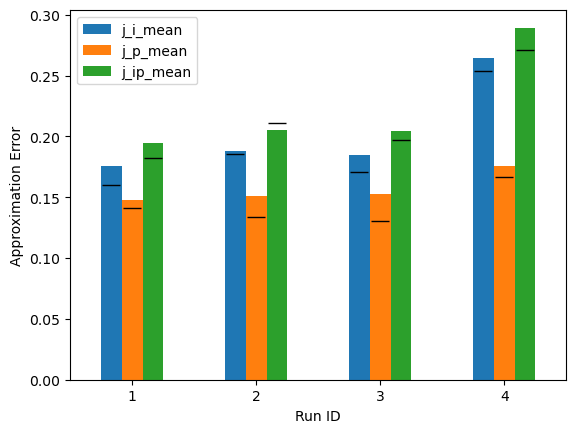

In [7]:
df = pd.read_csv("./experiments/ground_truth_scan.csv")
df = df.drop([0, 5, 6, 7, 8])
df = df.drop(df.columns[:11], axis=1)
df = df.rename(columns={"j_i": "j_i_mean", "j_p": "j_p_mean", "j_ip": "j_ip_mean"})
fig, ax = plt.subplots()
df.plot.bar(y=["j_i_mean", "j_p_mean", "j_ip_mean"], ylabel="Approximation Error", xlabel="Run ID", ax=ax, rot=0)
plt.plot(np.arange(len(list(df['j_i_mean'])))-0.17, list(df['j_i_median']), "k_", markersize=13)
plt.plot(np.arange(len(list(df['j_p_mean']))), list(df['j_p_median']), "k_", markersize=13)
plt.plot(np.arange(len(list(df['j_ip_mean'])))+0.17, list(df['j_ip_median']), "k_", markersize=13)
plt.legend()
df

In [15]:
# Preprocessed Results as table
df = pd.read_csv("./experiments/ground_truth_scan.csv")
df = df.drop([0, 2, 3, 4])
df = df[["Note", "ALPHA", "BETA", "U_BOUND", "j_i", "j_i_std", "j_p", "j_p_std", "j_ip", "j_ip_std"]]
df = df.round(3)
df

,Note,ALPHA,BETA,U_BOUND,j_i,j_i_std,j_p,j_p_std,j_ip,j_ip_std
1,Baseline,5,10,10,0.176,0.293,0.147,0.265,0.194,0.314
5,Preprocessed,5,10,10,0.198,0.315,0.166,0.273,0.215,0.332
6,Preprocessed,3,5,8,0.163,0.289,0.138,0.257,0.181,0.310
7,Preprocessed,3,3,6,0.173,0.295,0.143,0.255,0.191,0.315
8,Preprocessed,1,1,1,0.162,0.290,0.134,0.255,0.178,0.308


In [ ]:
with open("./table.tex", "w") as fp:
    df.to_latex(buf=fp, index=False)

In [ ]:
df_full = pd.read_csv("./experiments/pitch_approximation_results_uniform_styles.csv")
df_print = df_full.drop(list(range(3)))
df_print = df_print.drop(list(range(4,9)))
df_print = df_print.drop(df_print.columns[:6], axis=1)
df_print = df_print.drop(["N_RUNS", "j_i", "j_i_std", "j_p_std", "j_ip_std"], axis=1)
with open("./table.tex", "w") as fp:
    df_print.to_latex(buf=fp, index=False)

In [15]:
df_print

,U_BOUND,ZETA,PITCH_SHIFT_STD,j_p,j_ip
3,20,0.9954,6,0.179538,0.333215
9,10,1.0000,15,0.302010,0.430816
10,10,0.9954,15,0.145656,0.336743


## Statistics about The Sample Library

In [ ]:
from evoaudio.sample_library import SampleLibrary
lib = SampleLibrary()

In [4]:
from evoaudio.pitch import Pitch
df = pd.DataFrame(columns=["Instrument Name", "Number of Styles", "Minimum Pitch", "Maximum Pitch"])
style_counts = dict()
min_pitches = dict()
max_pitches = dict()
for instrument in lib.instruments:
    instr_info = lib.instruments[instrument]
    df.loc[len(df.index)] = {
        "Instrument Name": instrument, 
        "Number of Styles": len(instr_info.styles), 
        "Minimum Pitch": Pitch(min(list(instr_info.min_pitches.values()))).name, 
        "Maximum Pitch": Pitch(max(list(instr_info.max_pitches.values()))).name}
df

,Instrument Name,Number of Styles,Minimum Pitch,Maximum Pitch
0,Pinkillo,1,c5,c7
1,CeylonGuitar,1,c2,c4
2,BanjoFramus,1,a2,d6
3,Domra,1,c3,b5
4,Melodica,1,a3,c6
5,Piano,11,a0,c8
6,Bawu,1,b3,f5
7,Fujara,1,c2,c7
8,DallapeAccordion,1,b1,b6
9,Cello,9,c2,gis5


### Pitch and DrumHit MIDI Mappings

In [5]:
from evoaudio.pitch import DrumHit, Pitch
df = pd.DataFrame(columns=["MIDI Integer", "Pitch", "Drum Hit"])
for i in range(20, 109):
    pitch = Pitch(i).name
    hit = ""
    if i >= 36 and i <= 64:
        hit = DrumHit(i).name
    df.loc[len(df.index)] = { "MIDI Integer": i, "Pitch": pitch, "Drum Hit": hit }
df

,MIDI Integer,Pitch,Drum Hit
0,20,gis0,
1,21,a0,
2,22,ais0,
3,23,b0,
4,24,c1,
...,...,...,...
84,104,gis7,
85,105,a7,
86,106,ais7,
87,107,b7,
